### `jax` FLFM prototype implementation

In [1]:
import functools
from pathlib import Path

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
def open_image(path:Path) -> jnp.ndarray:
    img = Image.open(path)
    imgs = []
    for i in range(img.n_frames):
        img.seek(i)
        imgs.append(jnp.array(img))

    return jnp.stack(imgs, axis=0)

image = open_image("../data/yale/light_field_image.tif")
measured_psf = open_image("../data/yale/measured_psf.tif")
mirrored_psf = jnp.flip(measured_psf, axis=(-2, -1))

image.shape, measured_psf.shape

((1, 2048, 2048), (41, 2048, 2048))

In [3]:
# This is a single step of the RL deconvolution algorithm. The notation
# follows the notation from
def compute_step_f(
    O:jnp.ndarray, # [k, n, n]
    I:jnp.ndarray, # [1, n, n]
    PSF_fft:jnp.ndarray, # [k, n, n/2+1]
    PSFt_fft:jnp.ndarray, # [k, n, n/2+1]
) -> jnp.ndarray:
    denom = jnp.fft.irfft2(PSF_fft * jnp.fft.rfft2(O)).sum(axis=0, keepdims=True) # [1, n, n]
    img_err = I / denom
    return O * jnp.fft.fftshift(jnp.fft.irfft2(jnp.fft.rfft2(img_err) * PSFt_fft), axes=(-2, -1)) # [k, n, n]

jitted_step_f = jax.jit(
    compute_step_f,
)

In [4]:
# Our initial guess is 0.5 for all pixels
guess = jnp.ones_like(measured_psf) * 0.5

# Precompute the FFT of the PSFs
psf_fft = jnp.fft.rfft2(measured_psf)
psft_fft = jnp.fft.rfft2(mirrored_psf)

In [5]:
# Jax is JIT-compiled. This means that the first time we call it, it will
# trace the function and compile it for the cpu or gpu using the XLA compiler.
# We should be aware of the penalty of this compilation time.
# After the first call, the function will be cached and subsequent calls will be
# much faster.
_ = jitted_step_f(guess, image, psf_fft, psft_fft).block_until_ready()

In [6]:
# Now we can run the algorithm for 10 iterations
#
# Oddly, the first time this is run is 0.7s, but every subsequent time is 0.4s
# on my local V100
for _ in range(10):
    guess = compute_step_f(guess, image, psf_fft, psft_fft).block_until_ready()

### Post processing of the results
Apply the circle mask and save as a stacked `tiff`

In [7]:
def make_circle_mask(
    radius:int,
) -> jnp.ndarray:
    y, x = jnp.ogrid[:2*radius, :2*radius]
    circle_mask = (x - radius)**2 + (y - radius)**2 <= radius**2
    return circle_mask.astype(jnp.float32)

def post_processing(
    O:jnp.ndarray,
    center:tuple[int, int],
    radius:int,
) -> jnp.ndarray:
    circle_mask = jnp.expand_dims(make_circle_mask(radius), axis=0)
    sub_o = O[:, center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius]
    return sub_o * circle_mask

proc_guess = post_processing(guess, (1000, 980), 230)

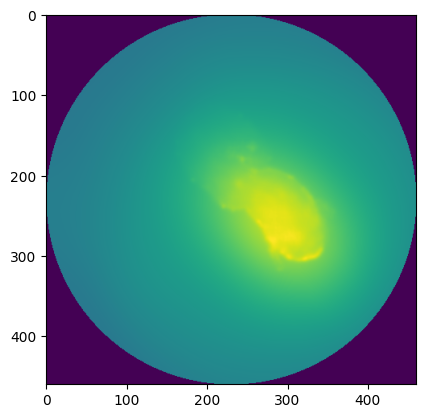

In [8]:
plt.imshow(proc_guess[21,...])

In [9]:
img = Image.fromarray(np.array(proc_guess[0]))
img.save(
    "jax_img.tif",
    format="tiff",
    append_images=[Image.fromarray(np.array(proc_guess[i])) for i in range(1, len(proc_guess))],
    save_all=True
)